In [4]:
import torch
from transformers import (BlipProcessor,
                          BlipForImageTextRetrieval,
                          BlipForConditionalGeneration,
                          BlipForQuestionAnswering)
from PIL import Image
from google.colab import files
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import requests
import numpy as np
import io
import json

# BlipForConditionalGeneration으로 랜드마크 caption 생성 후 groundtruth로 사용
# BlipForImageTextRetrieval로 groundtruth와 사용자가 찍은 사진 비교

# GPU 사용 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

@torch.no_grad()
def load_model(mode):

    if mode == "captioning":
        model_name = "Salesforce/blip-image-captioning-base"
        processor = BlipProcessor.from_pretrained(model_name)
        model = BlipForConditionalGeneration.from_pretrained(model_name).to(device)
    elif mode == "matching":
        model_name = "Salesforce/blip-itm-base-coco"
        processor = BlipProcessor.from_pretrained(model_name)
        model = BlipForImageTextRetrieval.from_pretrained(model_name).to(device)
    elif mode == "vqa":
        model_name = "ybelkada/blip-vqa-base"
        processor = BlipProcessor.from_pretrained(model_name)
        model = BlipForQuestionAnswering.from_pretrained(model_name)
    model.eval()
    return processor, model

sbert_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)
cap_processor, cap_model = load_model(mode="captioning")
mat_processor, mat_model = load_model(mode="matching")
vqa_processor, vqa_model = load_model(mode="vqa")

print(f"BLIP 모델 로드 완료. (사용 장치: {device})")

BLIP 모델 로드 완료. (사용 장치: cuda)


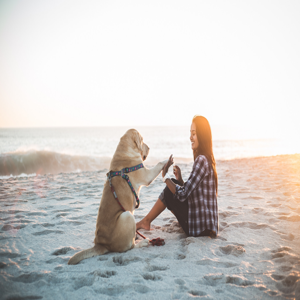

tensor([[-2.5427,  2.5479]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.5229]], device='cuda:0', grad_fn=<MmBackward0>)


In [11]:
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg'
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
display(raw_image.resize((300, 300)))

question = "A woman and a dog sitting together in a beach."
inputs = mat_processor(raw_image, question, return_tensors="pt").to("cuda")

itm_scores = mat_model(**inputs)[0]
cosine_score = mat_model(**inputs, use_itm_head=False)[0]

print(itm_scores)
print(cosine_score)

In [13]:
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg'
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

question = "how many dogs are in the picture?"
inputs = vqa_processor(raw_image, question, return_tensors="pt").to("cuda", torch.float16)

out = vqa_model.generate(**inputs)
print(vqa_processor.decode(out[0], skip_special_tokens=True))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

Ground Truth로 사용할 랜드마크 사진 1장을 업로드하세요:


Saving 지혜의숲1.webp to 지혜의숲1.webp

[업로드한 사진: 지혜의숲1.webp]


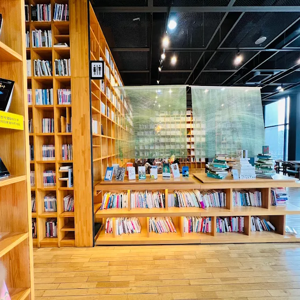


--- AI가 Ground Truth 캡션을 생성합니다 ---
  [기본 캡션]: a room with bookshels and shelves

[다양한 캡션 (JSON 후보 3개)]:
  - (후보 1): a room with bookshels and wooden shelves
  - (후보 2): a room with bookshels and shelves in it
  - (후보 3): a room with bookshels and shelves

--- 'missions.json'의 [ground_truth_captions]에 복사할 내용 ---
[
  "a room with bookshels and shelves",
  "a room with bookshels and wooden shelves",
  "a room with bookshels and shelves in it"
]


In [ ]:
print("Ground Truth로 사용할 랜드마크 사진 1장을 업로드하세요:")
uploaded = files.upload()

if len(uploaded) == 0:
    print("파일이 업로드되지 않았습니다.")
else:
    file_name = list(uploaded.keys())[0]
    image = Image.open(io.BytesIO(uploaded[file_name])).convert("RGB")

    print(f"\n[업로드한 사진: {file_name}]")
    display(image.resize((300, 300)))

    print("\n--- AI가 Ground Truth 캡션을 생성합니다 ---")

    # --- 1. 기본 캡션 (가장 확률 높은 캡션 1개) ---
    inputs = cap_processor(images=image, return_tensors="pt").to(device)
    outputs_greedy = cap_model.generate(**inputs, max_length=50)
    caption_greedy = cap_processor.decode(outputs_greedy[0], skip_special_tokens=True)
    print(f"  [기본 캡션]: {caption_greedy}")

    # [cite_start]--- 2. 다양한 캡션 생성 (BLIP 논문 추천 방식 [cite: 212, 216]) ---
    # Nucleus Sampling (top_p)을 사용해 더 다양하고 창의적인 캡션을 3개 생성
    print("\n[다양한 캡션 (JSON 후보 3개)]:")
    outputs_diverse = cap_model.generate(
        **inputs,
        max_length=50,
        num_beams=5,         # 빔 서치 개수
        do_sample=True,      # 샘플링 활성화
        top_p=0.9,           # Nucleus Sampling (상위 90% 확률 누적합 내에서 샘플링)
        num_return_sequences=3 # 3개의 다른 캡션 반환
    )

    generated_captions = []
    for i, output in enumerate(outputs_diverse):
        caption = cap_processor.decode(output, skip_special_tokens=True)
        # 기본 캡션과 겹치지 않게 추가 (선택 사항)
        if caption not in generated_captions and caption != caption_greedy:
             generated_captions.append(caption)
        print(f"  - (후보 {i+1}): {caption}")

    # --- 3. 최종 'missions.json'용 출력 ---
    # 기본 캡션도 후보에 포함
    if caption_greedy not in generated_captions:
        generated_captions.insert(0, caption_greedy)

    print("\n--- 'missions.json'의 [ground_truth_captions]에 복사할 내용 ---")
    print('[')
    for i, cap in enumerate(generated_captions):
        print(f'  "{cap}"{"," if i < len(generated_captions) - 1 else ""}')
    print(']')

In [ ]:
mission_data = """
[
  {
    "id": 1,
    "daily_keyword": "지식",
    "landmark_name": "지혜의 숲",
    "hint_text_1": "수만 권의 이야기가 쌓인 시간의 흔적을 찾아보세요.",
    "hint_text_2": "높은 서가들이 숲처럼 우거진 곳입니다.",
    "hint_text_3": "ㅈㅎㅇ ㅅ (초성 힌트)",
    "ground_truth_captions": [
    "a room with bookshels and shelves",
    "a room filled with lots of books and bookshels",
    "a room filled with lots of books and shelves",
    "a room filled with lots of books and booksheles",
    "a large wooden sculpture of a man on a wooden platform",
    "a group of people standing in front of a wooden sculpture",
    "a group of people standing in front of a sculpture",
    "a group of people standing in front of a statue",
    "a wooden sculpture of a woman sitting on a bench",
    "a woman sitting on a bench in front of a wall of books",
    "a woman sitting on a wooden bench in front of a wooden wall",
    "a woman sitting on a bench in a library"
    ],
    "score_threshold_low": 0.5,
    "score_threshold_high": 0.8
  }
]
"""
# ground_truth_captions는
missions = json.loads(mission_data)
today_mission = missions[0]
print("오늘의 미션 로드 완료.")

오늘의 미션 로드 완료.



--- 오늘의 미션: #지식 ---
수만 권의 이야기가 쌓인 시간의 흔적을 찾아보세요.

정답이라고 생각하는 사진을 업로드해주세요:


Saving 20160212134957017034443.jpg to 20160212134957017034443 (8).jpg

[업로드한 사진: 20160212134957017034443 (8).jpg]


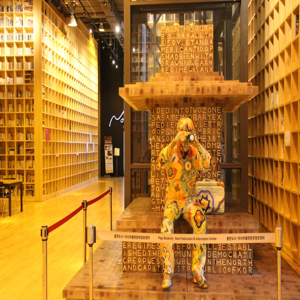


AI가 사진을 분석 중입니다...
a room with bookshels and shelves cosine score = 0.4241558909416199 tensor([[-0.9550,  0.9558]], device='cuda:0', grad_fn=<AddmmBackward0>) prob = 0.4004257619380951
a room filled with lots of books and bookshels cosine score = 0.4121250808238983 tensor([[-0.5612,  0.5598]], device='cuda:0', grad_fn=<AddmmBackward0>) prob = 0.3902755677700043
a room filled with lots of books and shelves cosine score = 0.42297908663749695 tensor([[-0.8158,  0.8143]], device='cuda:0', grad_fn=<AddmmBackward0>) prob = 0.39943718910217285
a room filled with lots of books and booksheles cosine score = 0.41193825006484985 tensor([[-0.5743,  0.5728]], device='cuda:0', grad_fn=<AddmmBackward0>) prob = 0.39011716842651367
a large wooden sculpture of a man on a wooden platform cosine score = 0.43634214997291565 tensor([[-1.5572,  1.5632]], device='cuda:0', grad_fn=<AddmmBackward0>) prob = 0.41060787439346313
a group of people standing in front of a wooden sculpture cosine score = 0.3294095993

In [ ]:
# --- 3. UI 및 이미지 업로드 ---
print(f"\n--- 오늘의 미션: #{today_mission['daily_keyword']} ---")
print(today_mission['hint_text_1'])
print("\n정답이라고 생각하는 사진을 업로드해주세요:")

uploaded = files.upload()

if len(uploaded) == 0:
    print("업로드된 파일이 없습니다. 셀을 다시 실행해주세요.")
else:
    # --- 4. 업로드된 이미지 처리 ---
    file_name = list(uploaded.keys())[0]
    user_image = Image.open(io.BytesIO(uploaded[file_name])).convert("RGB")
    print(f"\n[업로드한 사진: {file_name}]")
    display(user_image.resize((300, 300)))

# --- 5. 핵심 로직: 점수 계산 (BlipForImageTextRetrieval) ---
match_scores = []
gt_captions = today_mission['ground_truth_captions']

print("\nAI가 사진을 분석 중입니다...")

for gt_caption in gt_captions:
    # 이미지와 정답 캡션을 모델이 이해하도록 처리
    inputs = mat_processor(images=user_image, text=gt_caption, return_tensors="pt").to(device)

    # use_itm_head=False로 ITC 로짓(코사인 유사도 기반 점수)을 텐서로 가져옴
    # 출력 튜플의 첫 번째 요소[0]가 로짓입니다.
    cosine_score = mat_model(**inputs, use_itm_head=False)[0]
    item_scores = mat_model(**inputs)[0]

    # 시그모이드 함수를 적용하여 [0, 1] 확률로 변환
    prob_score_tensor = torch.tanh(cosine_score)
    print(gt_caption, "cosine score =", cosine_score.item(), item_scores, "prob =", prob_score_tensor.item())

    # .item()을 사용해 텐서에서 Python 숫자(float)만 추출합니다.
    prob_score_float = prob_score_tensor.item()

    # 리스트에는 순수 숫자만 추가됩니다.
    match_scores.append(prob_score_float)

# 가장 높은 매칭 점수를 최종 점수로 사용
best_score = max(match_scores)  # best_score는 이제 float입니다.

# --- 6. 힌트 및 피드백 기능 ---
# .item()이 필요 없이 f-string 포맷팅이 정상 작동합니다.
print(f"\n[AI 분석 결과] 최고 매칭 점수: {best_score*100:.2f}점")

low_threshold = today_mission['score_threshold_low']
high_threshold = today_mission['score_threshold_high']

if best_score > high_threshold:
    print("🎉 정답입니다! 미션 성공!")
    print("(보상: 100 마일리지 적립 💰)")
elif best_score > low_threshold:
    print(f"🤔 오! 거의 근접했어요! (점수: {best_score*100:.2f}점)")
    print(f"💡 힌트 2: {today_mission['hint_text_2']}")
else:
    print(f"아쉽네요. 힌트와는 조금 다른 것 같아요. (점수: {best_score*100:.2f}점)")
    print(f"💡 최종 힌트: {today_mission['hint_text_3']}")

In [ ]:
# --- 3. UI 및 이미지 업로드 ---
print(f"\n--- 오늘의 미션: #{today_mission['daily_keyword']} ---")
print(today_mission['hint_text_1'])
print("\n정답이라고 생각하는 사진을 업로드해주세요:")

uploaded = files.upload()

if len(uploaded) == 0:
    print("업로드된 파일이 없습니다. 셀을 다시 실행해주세요.")
else:
    # --- 4. 업로드된 이미지 처리 ---
    file_name = list(uploaded.keys())[0]
    user_image = Image.open(io.BytesIO(uploaded[file_name])).convert("RGB")
    print(f"\n[업로드한 사진: {file_name}]")
    display(user_image.resize((300, 300)))

# --- 5. 핵심 로직: 점수 계산 (BlipForImageTextRetrieval) ---
match_scores = []
gt_captions = today_mission['ground_truth_captions']

print("\nAI가 사진을 분석 중입니다...")

for gt_caption in gt_captions:
    # 이미지와 정답 캡션을 모델이 이해하도록 처리
    inputs = mat_processor(images=user_image, text=gt_caption, return_tensors="pt").to(device)

    # use_itm_head=False로 ITC 로짓(코사인 유사도 기반 점수)을 텐서로 가져옴
    # 출력 튜플의 첫 번째 요소[0]가 로짓입니다.
    logit_score_tensor = mat_model(**inputs, use_itm_head=False)[0]

    # 시그모이드 함수를 적용하여 [0, 1] 확률로 변환
    prob_score_tensor = torch.tanh(logit_score_tensor)

    # .item()을 사용해 텐서에서 Python 숫자(float)만 추출합니다.
    prob_score_float = prob_score_tensor.item()

    # 리스트에는 순수 숫자만 추가됩니다.
    match_scores.append(prob_score_float)

# 가장 높은 매칭 점수를 최종 점수로 사용
best_score = max(match_scores)  # best_score는 이제 float입니다.

# --- 6. 힌트 및 피드백 기능 ---
# .item()이 필요 없이 f-string 포맷팅이 정상 작동합니다.
print(f"\n[AI 분석 결과] 최고 매칭 점수: {best_score*100:.2f}점")

low_threshold = today_mission['score_threshold_low']
high_threshold = today_mission['score_threshold_high']

if best_score > high_threshold:
    print("🎉 정답입니다! 미션 성공!")
    print("(보상: 100 마일리지 적립 💰)")
elif best_score > low_threshold:
    print(f"🤔 오! 거의 근접했어요! (점수: {best_score*100:.2f}점)")
    print(f"💡 힌트 2: {today_mission['hint_text_2']}")
else:
    print(f"아쉽네요. 힌트와는 조금 다른 것 같아요. (점수: {best_score*100:.2f}점)")
    print(f"💡 최종 힌트: {today_mission['hint_text_3']}")

In [ ]:
# --- 3. UI 및 이미지 업로드 ---
print(f"\n--- 오늘의 미션: #{today_mission['daily_keyword']} ---")
print(today_mission['hint_text_1'])
print("\n정답이라고 생각하는 사진을 업로드해주세요:")

uploaded = files.upload()

if len(uploaded) == 0:
    print("업로드된 파일이 없습니다. 셀을 다시 실행해주세요.")
else:
    # --- 4. 업로드된 이미지 처리 ---
    file_name = list(uploaded.keys())[0]
    user_image = Image.open(io.BytesIO(uploaded[file_name])).convert("RGB")
    print(f"\n[업로드한 사진: {file_name}]")
    display(user_image.resize((300, 300)))

    # --- 5. 핵심 로직: 캡션 생성 + 텍스트 유사도 비교 ---

    # 5-1. 사용자 사진으로 캡션 생성
    print("\nAI가 사진 캡션을 생성 중입니다...")
    inputs_cap = cap_processor(images=user_image, return_tensors="pt").to(device)
    outputs_cap = cap_model.generate(**inputs_cap, max_length=50)
    user_caption = cap_processor.decode(outputs_cap[0], skip_special_tokens=True)
    print(f"  [생성된 캡션]: {user_caption}")

    print("생성된 캡션과 정답 캡션들의 유사도를 비교합니다...")

    # 5-2. 텍스트 임베딩 생성 (SBERT)
    gt_captions = today_mission['ground_truth_captions']

    # SBERT 모델로 캡션들을 벡터(임베딩)로 변환
    user_embedding = sbert_model.encode([user_caption])
    gt_embeddings = sbert_model.encode(gt_captions)

    # 5-3. 코사인 유사도 계산
    # (sklearn.metrics.pairwise.cosine_similarity 사용)
    # user_embedding (1, dim)과 gt_embeddings (N, dim) 비교
    sim_scores = cosine_similarity(user_embedding, gt_embeddings)

    # sim_scores는 2D 배열 (예: [[0.8, 0.7, 0.9]])이므로, max()로 최댓값 추출
    best_score = np.max(sim_scores)

    # --- 6. 힌트 및 피드백 기능 ---
    # SBERT 코사인 유사도 점수는 이미 [0, 1] 범위에 가까움
    print(f"\n[AI 분석 결과] 최고 캡션 유사도: {best_score*100:.2f}점")

    low_threshold = today_mission['score_threshold_low']
    high_threshold = today_mission['score_threshold_high']

    if best_score > high_threshold:
        print("🎉 정답입니다! 미션 성공!")
        print("(보상: 100 마일리지 적립 💰)")
    elif best_score > low_threshold:
        print(f"🤔 오! 거의 근접했어요! (점수: {best_score*100:.2f}점)")
        print(f"💡 힌트 2: {today_mission['hint_text_2']}")
    else:
        print(f"아쉽네요. 힌트와는 조금 다른 것 같아요. (점수: {best_score*100:.2f}점)")
        print(f"💡 최종 힌트: {today_mission['hint_text_3']}")

In [ ]:
# --- 3. UI 및 이미지 업로드 ---
print(f"\n--- 오늘의 미션: #{today_mission['daily_keyword']} ---")
print(today_mission['hint_text_1'])
print("\n정답이라고 생각하는 사진을 업로드해주세요:")

uploaded = files.upload()

if len(uploaded) == 0:
    print("업로드된 파일이 없습니다. 셀을 다시 실행해주세요.")
else:
    # --- 4. 업로드된 이미지 처리 ---
    file_name = list(uploaded.keys())[0]
    user_image = Image.open(io.BytesIO(uploaded[file_name])).convert("RGB")
    print(f"\n[업로드한 사진: {file_name}]")
    display(user_image.resize((300, 300)))

    # --- 5. 핵심 로직: 캡션 생성 + 텍스트 유사도 비교 ---

    # 5-1. 사용자 사진으로 캡션 생성
    print("\nAI가 사진 캡션을 생성 중입니다...")
    inputs_cap = cap_processor(images=user_image, return_tensors="pt").to(device)
    outputs_cap = cap_model.generate(**inputs_cap, max_length=50)
    user_caption = cap_processor.decode(outputs_cap[0], skip_special_tokens=True)
    print(f"  [생성된 캡션]: {user_caption}")

    print("생성된 캡션과 정답 캡션들의 유사도를 비교합니다...")

    # 5-2. 텍스트 임베딩 생성 (SBERT)
    gt_captions = today_mission['ground_truth_captions']

    # SBERT 모델로 캡션들을 벡터(임베딩)로 변환
    user_embedding = sbert_model.encode([user_caption])
    gt_embeddings = sbert_model.encode(gt_captions)

    # 5-3. 코사인 유사도 계산
    # (sklearn.metrics.pairwise.cosine_similarity 사용)
    # user_embedding (1, dim)과 gt_embeddings (N, dim) 비교
    sim_scores = cosine_similarity(user_embedding, gt_embeddings)

    # sim_scores는 2D 배열 (예: [[0.8, 0.7, 0.9]])이므로, max()로 최댓값 추출
    best_score = np.max(sim_scores)

    # --- 6. 힌트 및 피드백 기능 ---
    # SBERT 코사인 유사도 점수는 이미 [0, 1] 범위에 가까움
    print(f"\n[AI 분석 결과] 최고 캡션 유사도: {best_score*100:.2f}점")

    low_threshold = today_mission['score_threshold_low']
    high_threshold = today_mission['score_threshold_high']

    if best_score > high_threshold:
        print("🎉 정답입니다! 미션 성공!")
        print("(보상: 100 마일리지 적립 💰)")
    elif best_score > low_threshold:
        print(f"🤔 오! 거의 근접했어요! (점수: {best_score*100:.2f}점)")
        print(f"💡 힌트 2: {today_mission['hint_text_2']}")
    else:
        print(f"아쉽네요. 힌트와는 조금 다른 것 같아요. (점수: {best_score*100:.2f}점)")
        print(f"💡 최종 힌트: {today_mission['hint_text_3']}")

In [ ]:
# --- 3. UI 및 이미지 업로드 ---
print(f"\n--- 오늘의 미션: #{today_mission['daily_keyword']} ---")
print(today_mission['hint_text_1'])
print("\n정답이라고 생각하는 사진을 업로드해주세요:")

uploaded = files.upload()

if len(uploaded) == 0:
    print("업로드된 파일이 없습니다. 셀을 다시 실행해주세요.")
else:
    # --- 4. 업로드된 이미지 처리 ---
    file_name = list(uploaded.keys())[0]
    user_image = Image.open(io.BytesIO(uploaded[file_name])).convert("RGB")
    print(f"\n[업로드한 사진: {file_name}]")
    display(user_image.resize((300, 300)))

    # --- 5. 핵심 로직: 캡션 생성 + 텍스트 유사도 비교 ---

    # 5-1. 사용자 사진으로 캡션 생성
    print("\nAI가 사진 캡션을 생성 중입니다...")
    inputs_cap = cap_processor(images=user_image, return_tensors="pt").to(device)
    outputs_cap = cap_model.generate(**inputs_cap, max_length=50)
    user_caption = cap_processor.decode(outputs_cap[0], skip_special_tokens=True)
    print(f"  [생성된 캡션]: {user_caption}")

    print("생성된 캡션과 정답 캡션들의 유사도를 비교합니다...")

    # 5-2. 텍스트 임베딩 생성 (SBERT)
    gt_captions = today_mission['ground_truth_captions']

    # SBERT 모델로 캡션들을 벡터(임베딩)로 변환
    user_embedding = sbert_model.encode([user_caption])
    gt_embeddings = sbert_model.encode(gt_captions)

    # 5-3. 코사인 유사도 계산
    # (sklearn.metrics.pairwise.cosine_similarity 사용)
    # user_embedding (1, dim)과 gt_embeddings (N, dim) 비교
    sim_scores = cosine_similarity(user_embedding, gt_embeddings)

    # sim_scores는 2D 배열 (예: [[0.8, 0.7, 0.9]])이므로, max()로 최댓값 추출
    best_score = np.max(sim_scores)

    # --- 6. 힌트 및 피드백 기능 ---
    # SBERT 코사인 유사도 점수는 이미 [0, 1] 범위에 가까움
    print(f"\n[AI 분석 결과] 최고 캡션 유사도: {best_score*100:.2f}점")

    low_threshold = today_mission['score_threshold_low']
    high_threshold = today_mission['score_threshold_high']

    if best_score > high_threshold:
        print("🎉 정답입니다! 미션 성공!")
        print("(보상: 100 마일리지 적립 💰)")
    elif best_score > low_threshold:
        print(f"🤔 오! 거의 근접했어요! (점수: {best_score*100:.2f}점)")
        print(f"💡 힌트 2: {today_mission['hint_text_2']}")
    else:
        print(f"아쉽네요. 힌트와는 조금 다른 것 같아요. (점수: {best_score*100:.2f}점)")
        print(f"💡 최종 힌트: {today_mission['hint_text_3']}")

In [ ]:
print("Ground Truth로 사용할 랜드마크 사진 1장을 업로드하세요:")
uploaded = files.upload()

if len(uploaded) == 0:
    print("파일이 업로드되지 않았습니다.")
else:
    file_name = list(uploaded.keys())[0]
    image = Image.open(io.BytesIO(uploaded[file_name])).convert("RGB")

    print(f"\n[업로드한 사진: {file_name}]")
    display(image.resize((300, 300)))

    print("\n--- AI가 Ground Truth 캡션을 생성합니다 ---")

    # --- 1. 기본 캡션 (가장 확률 높은 캡션 1개) ---
    inputs = cap_processor(images=image, return_tensors="pt").to(device)
    outputs_greedy = cap_model.generate(**inputs, max_length=50)
    caption_greedy = cap_processor.decode(outputs_greedy[0], skip_special_tokens=True)
    print(f"  [기본 캡션]: {caption_greedy}")

    # [cite_start]--- 2. 다양한 캡션 생성 (BLIP 논문 추천 방식 [cite: 212, 216]) ---
    # Nucleus Sampling (top_p)을 사용해 더 다양하고 창의적인 캡션을 3개 생성
    print("\n[다양한 캡션 (JSON 후보 3개)]:")
    outputs_diverse = cap_model.generate(
        **inputs,
        max_length=50,
        num_beams=5,         # 빔 서치 개수
        do_sample=True,      # 샘플링 활성화
        top_p=0.9,           # Nucleus Sampling (상위 90% 확률 누적합 내에서 샘플링)
        num_return_sequences=3 # 3개의 다른 캡션 반환
    )

    generated_captions = []
    for i, output in enumerate(outputs_diverse):
        caption = cap_processor.decode(output, skip_special_tokens=True)
        # 기본 캡션과 겹치지 않게 추가 (선택 사항)
        if caption not in generated_captions and caption != caption_greedy:
             generated_captions.append(caption)
        print(f"  - (후보 {i+1}): {caption}")

    # --- 3. 최종 'missions.json'용 출력 ---
    # 기본 캡션도 후보에 포함
    if caption_greedy not in generated_captions:
        generated_captions.insert(0, caption_greedy)

    print("\n--- 'missions.json'의 [ground_truth_captions]에 복사할 내용 ---")
    print('[')
    for i, cap in enumerate(generated_captions):
        print(f'  "{cap}"{"," if i < len(generated_captions) - 1 else ""}')
    print(']')

사진에 사람이 있으면 사람들의 행동에 대해 캡셔닝함.

-> prompt를 주면 해결 가능

In [ ]:
print("Ground Truth로 사용할 랜드마크 사진 1장을 업로드하세요:")
uploaded = files.upload()
prompt_text = "this place is"

if len(uploaded) == 0:
    print("파일이 업로드되지 않았습니다.")
else:
    file_name = list(uploaded.keys())[0]
    image = Image.open(io.BytesIO(uploaded[file_name])).convert("RGB")

    print(f"\n[업로드한 사진: {file_name}]")
    display(image.resize((300, 300)))

    print("\n--- AI가 Ground Truth 캡션을 생성합니다 ---")

    # --- 1. 기본 캡션 (가장 확률 높은 캡션 1개) ---
    inputs = cap_processor(images=image,
                           text=prompt_text,
                           return_tensors="pt").to(device)
    outputs_greedy = cap_model.generate(**inputs, max_length=50)
    caption_greedy = cap_processor.decode(outputs_greedy[0], skip_special_tokens=True)
    print(f"  [기본 캡션]: {caption_greedy}")

    # [cite_start]--- 2. 다양한 캡션 생성 (BLIP 논문 추천 방식 [cite: 212, 216]) ---
    # Nucleus Sampling (top_p)을 사용해 더 다양하고 창의적인 캡션을 3개 생성
    print("\n[다양한 캡션 (JSON 후보 3개)]:")
    outputs_diverse = cap_model.generate(
        **inputs,
        max_length=50,
        num_beams=5,         # 빔 서치 개수
        do_sample=True,      # 샘플링 활성화
        top_p=0.9,           # Nucleus Sampling (상위 90% 확률 누적합 내에서 샘플링)
        num_return_sequences=3 # 3개의 다른 캡션 반환
    )

    generated_captions = []
    for i, output in enumerate(outputs_diverse):
        caption = cap_processor.decode(output, skip_special_tokens=True)
        # 기본 캡션과 겹치지 않게 추가 (선택 사항)
        if caption not in generated_captions and caption != caption_greedy:
             generated_captions.append(caption)
        print(f"  - (후보 {i+1}): {caption}")

    # --- 3. 최종 'missions.json'용 출력 ---
    # 기본 캡션도 후보에 포함
    if caption_greedy not in generated_captions:
        generated_captions.insert(0, caption_greedy)

    print("\n--- 'missions.json'의 [ground_truth_captions]에 복사할 내용 ---")
    print('[')
    for i, cap in enumerate(generated_captions):
        print(f'  "{cap}"{"," if i < len(generated_captions) - 1 else ""}')
    print(']')

In [ ]:
print("Ground Truth로 사용할 랜드마크 사진 1장을 업로드하세요:")
uploaded = files.upload()
prompt_text = "fuck is "

if len(uploaded) == 0:
    print("파일이 업로드되지 않았습니다.")
else:
    file_name = list(uploaded.keys())[0]
    image = Image.open(io.BytesIO(uploaded[file_name])).convert("RGB")

    print(f"\n[업로드한 사진: {file_name}]")
    display(image.resize((300, 300)))

    print("\n--- AI가 Ground Truth 캡션을 생성합니다 ---")

    # --- 1. 기본 캡션 (가장 확률 높은 캡션 1개) ---
    inputs = cap_processor(images=image,
                           text=prompt_text,
                           return_tensors="pt").to(device)
    outputs_greedy = cap_model.generate(**inputs, max_length=50)
    caption_greedy = cap_processor.decode(outputs_greedy[0], skip_special_tokens=True)
    print(f"  [기본 캡션]: {caption_greedy}")

    # [cite_start]--- 2. 다양한 캡션 생성 (BLIP 논문 추천 방식 [cite: 212, 216]) ---
    # Nucleus Sampling (top_p)을 사용해 더 다양하고 창의적인 캡션을 3개 생성
    print("\n[다양한 캡션 (JSON 후보 3개)]:")
    outputs_diverse = cap_model.generate(
        **inputs,
        max_length=50,
        num_beams=5,         # 빔 서치 개수
        do_sample=True,      # 샘플링 활성화
        top_p=0.9,           # Nucleus Sampling (상위 90% 확률 누적합 내에서 샘플링)
        num_return_sequences=3 # 3개의 다른 캡션 반환
    )

    generated_captions = []
    for i, output in enumerate(outputs_diverse):
        caption = cap_processor.decode(output, skip_special_tokens=True)
        # 기본 캡션과 겹치지 않게 추가 (선택 사항)
        if caption not in generated_captions and caption != caption_greedy:
             generated_captions.append(caption)
        print(f"  - (후보 {i+1}): {caption}")

    # --- 3. 최종 'missions.json'용 출력 ---
    # 기본 캡션도 후보에 포함
    if caption_greedy not in generated_captions:
        generated_captions.insert(0, caption_greedy)

    print("\n--- 'missions.json'의 [ground_truth_captions]에 복사할 내용 ---")
    print('[')
    for i, cap in enumerate(generated_captions):
        print(f'  "{cap}"{"," if i < len(generated_captions) - 1 else ""}')
    print(']')

In [ ]:
print("Ground Truth로 사용할 랜드마크 사진 1장을 업로드하세요:")
uploaded = files.upload()
prompt_text = "The emotion felt in this photo is"

if len(uploaded) == 0:
    print("파일이 업로드되지 않았습니다.")
else:
    file_name = list(uploaded.keys())[0]
    image = Image.open(io.BytesIO(uploaded[file_name])).convert("RGB")

    print(f"\n[업로드한 사진: {file_name}]")
    display(image.resize((300, 300)))

    print("\n--- AI가 Ground Truth 캡션을 생성합니다 ---")

    # --- 1. 기본 캡션 (가장 확률 높은 캡션 1개) ---
    inputs = cap_processor(images=image,
                           text=prompt_text,
                           return_tensors="pt").to(device)
    outputs_greedy = cap_model.generate(**inputs, max_length=50)
    caption_greedy = cap_processor.decode(outputs_greedy[0], skip_special_tokens=True)
    print(f"  [기본 캡션]: {caption_greedy}")

    # [cite_start]--- 2. 다양한 캡션 생성 (BLIP 논문 추천 방식 [cite: 212, 216]) ---
    # Nucleus Sampling (top_p)을 사용해 더 다양하고 창의적인 캡션을 3개 생성
    print("\n[다양한 캡션 (JSON 후보 3개)]:")
    outputs_diverse = cap_model.generate(
        **inputs,
        max_length=50,
        num_beams=5,         # 빔 서치 개수
        # do_sample=True,      # 샘플링 활성화
        # top_p=0.9,           # Nucleus Sampling (상위 90% 확률 누적합 내에서 샘플링)
        num_return_sequences=3 # 3개의 다른 캡션 반환
    )

    generated_captions = []
    for i, output in enumerate(outputs_diverse):
        caption = cap_processor.decode(output, skip_special_tokens=True)
        # 기본 캡션과 겹치지 않게 추가 (선택 사항)
        if caption not in generated_captions and caption != caption_greedy:
             generated_captions.append(caption)
        print(f"  - (후보 {i+1}): {caption}")

    # --- 3. 최종 'missions.json'용 출력 ---
    # 기본 캡션도 후보에 포함
    if caption_greedy not in generated_captions:
        generated_captions.insert(0, caption_greedy)

    print("\n--- 'missions.json'의 [ground_truth_captions]에 복사할 내용 ---")
    print('[')
    for i, cap in enumerate(generated_captions):
        print(f'  "{cap}"{"," if i < len(generated_captions) - 1 else ""}')
    print(']')

In [ ]:
print("Ground Truth로 사용할 랜드마크 사진 1장을 업로드하세요:")
uploaded = files.upload()
prompt_text = "The emotion felt in this photo is"

if len(uploaded) == 0:
    print("파일이 업로드되지 않았습니다.")
else:
    file_name = list(uploaded.keys())[0]
    image = Image.open(io.BytesIO(uploaded[file_name])).convert("RGB")

    print(f"\n[업로드한 사진: {file_name}]")
    display(image.resize((300, 300)))

    print("\n--- AI가 Ground Truth 캡션을 생성합니다 ---")

    # --- 1. 기본 캡션 (가장 확률 높은 캡션 1개) ---
    inputs = cap_processor(images=image,
                           text=prompt_text,
                           return_tensors="pt").to(device)
    outputs_greedy = cap_model.generate(**inputs, max_length=50)
    caption_greedy = cap_processor.decode(outputs_greedy[0], skip_special_tokens=True)
    print(f"  [기본 캡션]: {caption_greedy}")

    # [cite_start]--- 2. 다양한 캡션 생성 (BLIP 논문 추천 방식 [cite: 212, 216]) ---
    # Nucleus Sampling (top_p)을 사용해 더 다양하고 창의적인 캡션을 3개 생성
    print("\n[다양한 캡션 (JSON 후보 3개)]:")
    outputs_diverse = cap_model.generate(
        **inputs,
        max_length=50,
        num_beams=5,         # 빔 서치 개수
        # do_sample=True,      # 샘플링 활성화
        # top_p=0.9,           # Nucleus Sampling (상위 90% 확률 누적합 내에서 샘플링)
        num_return_sequences=3 # 3개의 다른 캡션 반환
    )

    generated_captions = []
    for i, output in enumerate(outputs_diverse):
        caption = cap_processor.decode(output, skip_special_tokens=True)
        # 기본 캡션과 겹치지 않게 추가 (선택 사항)
        if caption not in generated_captions and caption != caption_greedy:
             generated_captions.append(caption)
        print(f"  - (후보 {i+1}): {caption}")

    # --- 3. 최종 'missions.json'용 출력 ---
    # 기본 캡션도 후보에 포함
    if caption_greedy not in generated_captions:
        generated_captions.insert(0, caption_greedy)

    print("\n--- 'missions.json'의 [ground_truth_captions]에 복사할 내용 ---")
    print('[')
    for i, cap in enumerate(generated_captions):
        print(f'  "{cap}"{"," if i < len(generated_captions) - 1 else ""}')
    print(']')